In [1]:
from collections import OrderedDict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mne import Epochs, find_events
from mne.decoding import Vectorizer

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

from pyriemann.estimation import ERPCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM
from pyriemann.spatialfilters import Xdawn

from experiments import eventRelatedPotential
from dataset import brainflowDataset
from utils import plot_conditions

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


# N170

<img style="height: 300px; float: right" src="https://www.researchgate.net/profile/Vincent_Walsh3/publication/49833438/figure/fig1/AS:394279194251295@1471014893499/The-P1-and-N170-ERP-components-The-graph-shows-the-grand-average-ERP-responses-from-ten.png"/>

The N170 is a large negative event-related potential (ERP) component that occurs after the detection of faces, but not 
objects, scrambled faces, or other body parts such as hands. The N170 occurs around 170ms after face perception and is 
most easily detected at lateral posterior electrodes such as T5 and T6 [1](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.601.6917&rep=rep1&type=pdf). 
Frontal or profile views of human (and animal [2](https://www.ncbi.nlm.nih.gov/pubmed/14995895)) faces elicit the strongest 
N170 and the strength of the N170 does not seem to be influenced by how familiar a face is. Thus, although there is no 
consensus on the specific source of the N170, researchers believe it is related to activity in the fusiform face area, 
an area of the brain that shows a similar response pattern and is involved in encoding the holistic representation of a face 
(i.e eyes, nose mouth all arranged in the appropriate way).

In this notebook, we will attempt to detect the N170 with the OpenBCI Headset using faces and houses as our stimuli. 
The OpenBCI's temporal electrodes are well positioned to detect the N170 and we expect we'll be able to 
see an N170 emerge from just a few dozen trials. We will then run several different classification algorithms on our 
data in order to evaluate the performance of a potential brain-computer interface using the N170.

## Set up the experiment

In [2]:
n170_exp = eventRelatedPotential(erp='n170')

## Initialize the EEG signal

In [3]:
# For testing without connection
#n170_exp.initialize_eeg(board_type='synthetic')

# For using the 4-channel Ganglion board
#   Over USB:
#n170_exp.initialize_eeg(board_type='ganglion')
#   Over Wifi:
#n170_exp.initialize_eeg(board_type='ganglion_wifi)


# For using the 8-channel Cyton board
#   Over USB:
#n170_exp.initialize_eeg(board_type='cyton')
#   Over Wifi:
#n170_exp.initialize_eeg(board_type='cyton_wifi')


# For using the 16-channel Cyton+Daisy combo
#   Over USB:
n170_exp.initialize_eeg(board_type='cyton_daisy')
#   Over Wifi:
#n170_exp.initialize_eeg(board_type='cyton_daisy_wifi')

# For using the BrainBit headband:
#n170_exp.initialize_eeg(board_type='brainbit')

# For using the Unicorn device
#n170_exp.initialize_eeg(board_type='unicorn')

cyton_daisy
/dev/ttyUSB0


## Run Experiment

In [4]:
subject_name = 'jadin_test'
duration = 10
trial_num = 3
n170_exp.run_trial(duration=duration,
                   subject=subject_name,
                   run=trial_num)

Beginning EEG Stream; Wait 5 seconds for signal to settle... 



## Load the Dataset

In [2]:
subject_name = 'jadin_test'
runs = [3]
dataset_n170 = brainflowDataset(paradigm='n170', 
                                subject=subject_name,
                                board_type='cyton_daisy')
raw = dataset_n170.load_subject_to_raw(subject_name, runs)

data/jadin_test_n170_3.csv
Notch filter
Bandpass filter
Denoise
Creating RawArray with float64 data, n_channels=16, n_times=504
    Range : 0 ... 503 =      0.000 ...     4.024 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=504
    Range : 0 ... 503 =      0.000 ...     4.024 secs
Ready.


## Filter the data
The justification for filtering 1-16 Hz is taken from... [**Find reference from Riemannian Geometric Classifier paper**]

In [7]:
raw.filter(1, 16, method='iir')

Filtering raw data in 6 contiguous segments
Setting up band-pass filter from 1 - 16 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 16.00 Hz: -6.02, -6.02 dB



<RawArray | 17 x 45199 (361.6 s), ~5.9 MB, data loaded>

## Epoch the data

In [8]:
events = find_events(raw)
event_id = {'Non-Target': 1, 'Target': 2}
epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-0.1, tmax=0.8, baseline=None,
                reject={'eeg': 100e-6}, preload=True, 
                verbose=False)
print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)

360 events found
Event IDs: [1 2]
sample drop %:  6.944444444444442


## Analyze data

#### Epoch Averages

AttributeError: module 'seaborn' has no attribute 'tsplot'

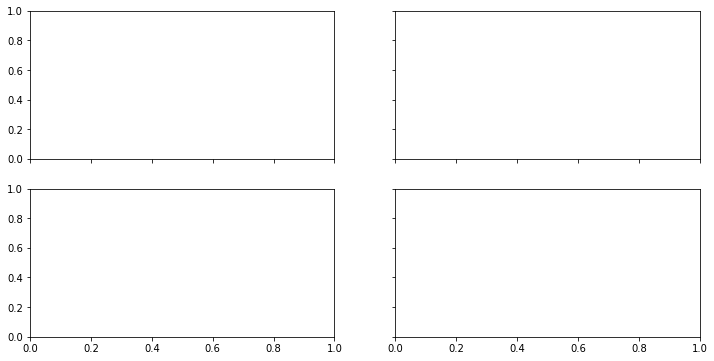

In [9]:
%matplotlib inline
conditions = OrderedDict()
conditions['Non-target'] = [1]
conditions['Target'] = [2]

fig, ax = plot_conditions(epochs, conditions=conditions, 
                                ci=97.5, n_boot=1000, title='',
                                diff_waveform=(1, 2))

### Classify

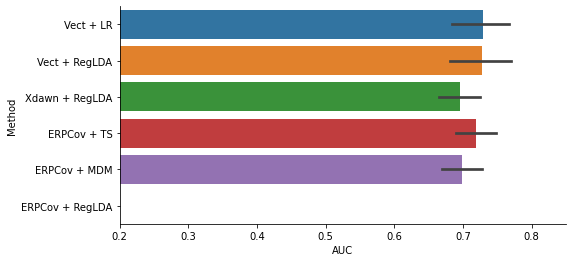

In [10]:
clfs = OrderedDict()

clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['Xdawn + RegLDA'] = make_pipeline(Xdawn(2, classes=[1]), Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['ERPCov + TS'] = make_pipeline(ERPCovariances(), TangentSpace(), LogisticRegression())
clfs['ERPCov + MDM'] = make_pipeline(ERPCovariances(), MDM())

# format data
epochs.pick_types(eeg=True)
X = epochs.get_data() * 1e6
times = epochs.times
y = epochs.events[:, -1]

# define cross validation 
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=42)

# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    res = cross_val_score(clfs[m], X, y==2, scoring='roc_auc', cv=cv, n_jobs=-1)
    auc.extend(res)
    methods.extend([m]*len(res))
    
results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

plt.figure(figsize=[8,4])
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.2, 0.85)
sns.despine()